In [1]:
import pandas as pd
import os
import csv
import logging
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from concurrent.futures import ThreadPoolExecutor
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

directory = "C:/Users/pillya/Documents/ish/vkr/datasets"

def convert_tsv_to_csv(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.tsv'):
            tsv_file = os.path.join(directory, filename)
            csv_file = os.path.join(directory, filename.replace('.tsv', '.csv'))
            try:
                with open(tsv_file, 'r', newline='', encoding='utf-8') as infile, open(csv_file, 'w', newline='', encoding='utf-8') as outfile:
                    reader = csv.reader(infile, delimiter='\t')
                    writer = csv.writer(outfile)
                    for row in reader:
                        writer.writerow(row)
                logging.info(f'Converted {tsv_file} to {csv_file}')
            except Exception as e:
                logging.error(f"Error converting {tsv_file}: {e}")

def process_csv_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            file_path = os.path.join(directory, filename)
            try:
                df = pd.read_csv(file_path, header=None)
                df.columns = ['text', 'value']
                df.to_csv(file_path, index=False)
                logging.info(f'Successfully processed and overwritten {filename}')
            except PermissionError as e:
                logging.error(f"Permission error for {filename}: {e}")
            except FileNotFoundError as e:
                logging.error(f"File not found: {e}")
            except Exception as e:
                logging.error(f"An error occurred while processing {filename}: {e}")

2024-12-24 13:52:56,261 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\ger.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\ger.csv
2024-12-24 13:52:56,304 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\gre.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\gre.csv
2024-12-24 13:52:56,330 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\rus.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\rus.csv
2024-12-24 13:52:56,355 - INFO - Converted C:/Users/pillya/Documents/ish/vkr/datasets\tur.tsv to C:/Users/pillya/Documents/ish/vkr/datasets\tur.csv
2024-12-24 13:52:56,430 - INFO - Successfully processed and overwritten ger.csv
2024-12-24 13:52:56,491 - INFO - Successfully processed and overwritten gre.csv
2024-12-24 13:52:56,527 - INFO - Successfully processed and overwritten rus.csv
2024-12-24 13:52:56,557 - INFO - Successfully processed and overwritten tur.csv
2024-12-24 13:52:56,623 - INFO - Очистка прошла успешно C:/Users/pillya/Documents/ish/vk

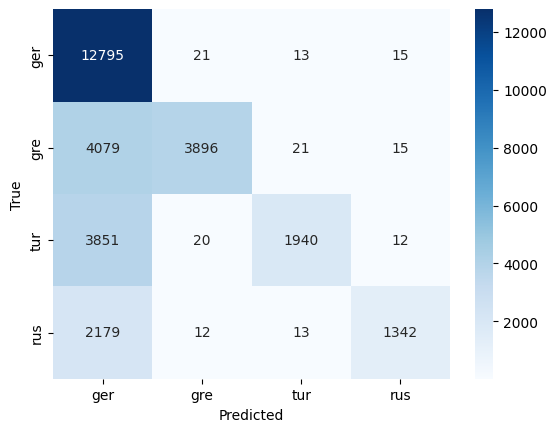

Введите несколько слов на любом языке, и модель предскажет язык:


2024-12-24 13:53:07,141 - INFO -   language         text value
0      ger           1.     O
1      ger          Auf     O
2      ger          die     O
3      ger     Revision     O
4      ger          des     O
5      ger  Angeklagten     O
6      ger         wird     O
7      ger          das     O
8      ger       Urteil     O
9      ger          der     O
2024-12-24 13:53:07,149 - INFO - language
ger    64219
gre    40054
rus    29113
tur    17730
Name: count, dtype: int64
2024-12-24 13:53:07,151 - INFO - [[0. 0. 0. ... 0. 0. 0.]]


Предсказанный язык: ger


2024-12-24 13:53:07,405 - INFO -               precision    recall  f1-score   support

         ger       0.56      1.00      0.72     12844
         gre       0.99      0.49      0.65      8011
         rus       0.98      0.33      0.50      5823
         tur       0.97      0.38      0.54      3546

    accuracy                           0.66     30224
   macro avg       0.87      0.55      0.60     30224
weighted avg       0.80      0.66      0.64     30224

2024-12-24 13:53:07,406 - INFO - Text: )
True Language: gre
Predicted Language: ger

2024-12-24 13:53:07,408 - INFO - Text: işi
True Language: tur
Predicted Language: ger

2024-12-24 13:53:07,409 - INFO - Text: einen
True Language: ger
Predicted Language: ger

2024-12-24 13:53:07,411 - INFO - Text: Landgericht
True Language: ger
Predicted Language: ger

2024-12-24 13:53:07,412 - INFO - Text: Κάθε
True Language: gre
Predicted Language: gre

2024-12-24 13:53:07,413 - INFO - Предсказанный язык: rus


In [2]:
def load_dataset(file_path):
    return pd.read_csv(file_path)

def clean_dataset(df):
    df = df.dropna(subset=['text', 'value'])
    df = df[df['text'].str.strip() != '']
    df = df[df['value'].str.strip() != '']
    df = df[df['text'].apply(lambda x: all(c.isprintable() for c in x))]
    df = df[df['value'].apply(lambda x: all(c.isprintable() for c in x))]
    return df

def load_and_clean_datasets(directory, languages):
    datasets = []
    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(load_and_clean_dataset, directory, lang) for lang in languages]
        for future in futures:
            df = future.result()
            if df is not None:
                datasets.append(df)
    return datasets

def load_and_clean_dataset(directory, lang):
    file_path = os.path.join(directory, f'{lang}.csv')
    try:
        df = load_dataset(file_path)
        df = clean_dataset(df)
        logging.info(f'Очистка прошла успешно {file_path}')
        return df
    except PermissionError as e:
        logging.error(f"Permission error: {e}")
    except FileNotFoundError as e:
        logging.error(f"File not found: {e}")
    except Exception as e:
        logging.error(f"An error occurred: {e}")
    return None

def main():
    convert_tsv_to_csv(directory)
    process_csv_files(directory)

    languages = ['ger', 'gre', 'tur', 'rus']
    datasets = load_and_clean_datasets(directory, languages)

    combined_df = pd.concat(datasets, keys=languages, names=['language', 'index'])
    combined_df = combined_df.reset_index(level=1, drop=True).reset_index()

    train_df, test_df = train_test_split(combined_df, test_size=0.2, random_state=42, stratify=combined_df['language'])

    if '1.' in train_df.columns:
        train_df.rename(columns={'1.': 'text'}, inplace=True)
    if '1.' in test_df.columns:
        test_df.rename(columns={'1.': 'text'}, inplace=True)
    if 'text' not in train_df.columns:
        raise KeyError("Столбец 'text' не найден в train_df")
    if 'text' not in test_df.columns:
        raise KeyError("Столбец 'text' не найден в test_df")

    vectorizer = TfidfVectorizer(max_features=5000)
    X_train = vectorizer.fit_transform(train_df['text'].dropna())
    X_test = vectorizer.transform(test_df['text'].dropna())
    y_train = train_df['language']
    y_test = test_df['language']
    logging.info("Векторизация выполнена успешно")

    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    logging.info(classification_report(y_test, y_pred))

    y_pred = model.predict(X_test)
    logging.info(classification_report(y_test, y_pred))

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=languages, yticklabels=languages)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    joblib.dump(model, 'language_classifier.pkl')
    joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

    model = joblib.load('language_classifier.pkl')
    vectorizer = joblib.load('tfidf_vectorizer.pkl')

    def predict_language(text):
        text_vectorized = vectorizer.transform([text])
        predicted_language = model.predict(text_vectorized)[0]
        return predicted_language

    print("Введите несколько слов на любом языке, и модель предскажет язык:")
    user_input = input("Ввод: ")
    predicted_language = predict_language(user_input)
    print(f"Предсказанный язык: {predicted_language}")

    # Проверка данных
    logging.info(combined_df.head(10))
    logging.info(combined_df['language'].value_counts())
    sample_text = "Доброе утро"
    sample_vectorized = vectorizer.transform([sample_text])
    logging.info(sample_vectorized.toarray())
    y_pred = model.predict(X_test)
    logging.info(classification_report(y_test, y_pred))
    for i in range(5):
        sample_text = test_df['text'].iloc[i]
        sample_vectorized = vectorizer.transform([sample_text])
        predicted_language = model.predict(sample_vectorized)[0]
        true_language = test_df['language'].iloc[i]
        logging.info(f"Text: {sample_text}\nTrue Language: {true_language}\nPredicted Language: {predicted_language}\n")

    user_input = "Россия"
    predicted_language = predict_language(user_input)
    logging.info(f"Предсказанный язык: {predicted_language}")

if __name__ == "__main__":
    main()